In [1]:
import pandas as pd
import numpy as np
from scipy import stats as sp
import sys, os
sys.path.append('../')
import trace_analysis
import plots_analysis
import trace_statistics

# KNN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
# SVM
from sklearn import svm
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

# Data Preparation


Prepare the data to be used with kNN

In [7]:
plots = [("traces/normal", 'grid9_normal_2019-02-11_17:51:17_'),
         ("traces/normal", 'grid9_normal_2019-02-11_20:22:01_'),
         ("traces/normal", 'grid9_normal_2019-02-11_21:03:19_'),
         ("traces/normal", 'grid9_normal_2019-02-12_14:02:32_'),
         ("traces/normal", 'grid9_normal_2019-02-12_14:22:43_'),
         ("traces/1bh-3", 'grid9_1bh-3_2019-02-12_14:47:14_'),         
         ("traces/1bh-6", 'grid9_1bh-6_2019-02-11_20:48:08_'),
         ("traces/1bh-6", 'grid9_1bh-6_2019-02-11_21:03:19_'),
         ("traces/1bh-6", 'grid9_1bh-6_2019-02-12_13:35:47_'),
         ("traces/1bh-7", 'grid9_1bh-7_2019-02-12_14:02:32_'),
         ("traces/1bh-7", 'grid9_1bh-7_2019-02-12_14:22:43_'),         
         ("traces/1bh-3", 'grid9_1bh-3_2019-02-12_14:47:14_')
        ]

stats = None
win_25_stats = None
win_50_stats = None
win_100_stats = None

for row in plots:
    label = 'Normal'
    
    # Assign a label
    if row[0].find('gh') >= 0:
        label = 'Gray Hole'
    elif row[0].find('bh') >= 0:
        label = 'Black Hole'
    nodes, packets_node = trace_analysis.process_cooja2_traces(row[0], row[1])
    
    # Update stats
    if stats is None:
        stats = trace_statistics.compute_labeled_statistics(nodes, packets_node, label)
        win_25_stats = trace_statistics.compute_window_labeled_statistics(nodes, packets_node, label, 25)
        win_50_stats = trace_statistics.compute_window_labeled_statistics(nodes, packets_node, label, 50)
        win_100_stats = trace_statistics.compute_window_labeled_statistics(nodes, packets_node, label, 100)
    else:
        stats = pd.concat([stats, trace_statistics.compute_labeled_statistics(nodes, packets_node, label)])
        win_25_stats = pd.concat([win_25_stats, trace_statistics.compute_window_labeled_statistics(nodes, packets_node, label, 25)])
        win_50_stats = pd.concat([win_50_stats, trace_statistics.compute_window_labeled_statistics(nodes, packets_node, label, 50)])
        win_100_stats = pd.concat([win_100_stats, trace_statistics.compute_window_labeled_statistics(nodes, packets_node, label, 100)])
        
stats = stats.reset_index(drop=True)
win_25_stats = win_25_stats.reset_index(drop=True)
win_50_stats = win_50_stats.reset_index(drop=True)
win_100_stats = win_100_stats.reset_index(drop=True)
stats.head(5)

,node_id,count,mean,var,std,hop,min,max,loss,label
0,fd00::212:7405:5:505:,98,169.887755,4927.317168,70.194851,3,107.0,494.0,0.510,Normal
1,fd00::212:7404:4:404:,87,163.327586,31382.584812,177.151305,2,77.3,1205.0,0.565,Normal
2,fd00::212:7403:3:303:,92,60.042391,5431.264227,73.697111,1,28.3,707.0,0.540,Normal
3,fd00::212:7408:8:808:,90,233.155556,7211.548564,84.920837,4,169.0,929.0,0.550,Normal
4,fd00::212:7402:2:202:,99,145.127273,33352.392004,182.626373,2,69.4,1726.0,0.505,Normal


Select the set of features and labels that we use to fit the algorithm

In [24]:
# separate features from target values
features = stats.drop(columns=['node_id', 'label'])
target = stats['label'].values
print('Targets: ' + str(set(target)))

# split dataset into train and test data
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=1)

Targets: {'Normal', 'Black Hole'}


# K-Nearest Neighbor (KNN) Classification

Let us first observe the accuracies for different values of k

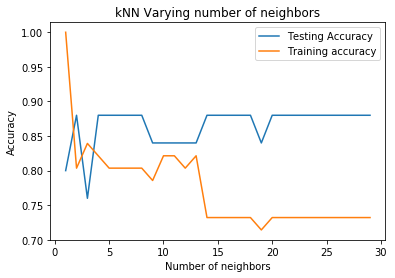

In [25]:
trace_analysis.knn_test_number_of_neighbors(X_train, X_test, y_train, y_test)

Let's build KNN classifier 

In [26]:
#Create KNN Classifier
knn = KNeighborsClassifier(n_neighbors=5)

#Train the model using the training sets
knn.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = knn.predict(X_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

print("\n\n",classification_report(y_test,y_pred))


Accuracy: 0.88


               precision    recall  f1-score   support

  Black Hole       0.95      0.91      0.93        22
      Normal       0.50      0.67      0.57         3

   micro avg       0.88      0.88      0.88        25
   macro avg       0.73      0.79      0.75        25
weighted avg       0.90      0.88      0.89        25



# Support Vector Machines (SVM) Classification

Let us experiment with another classifier

In [27]:
#Create a svm Classifier
svm_clf = svm.SVC(kernel='linear', random_state=9, gamma='scale') # Linear Kernel

#Train the model using the training sets
svm_clf.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = svm_clf.predict(X_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

print("\n\n",classification_report(y_test,y_pred))

Accuracy: 0.8


               precision    recall  f1-score   support

  Black Hole       0.95      0.82      0.88        22
      Normal       0.33      0.67      0.44         3

   micro avg       0.80      0.80      0.80        25
   macro avg       0.64      0.74      0.66        25
weighted avg       0.87      0.80      0.83        25



# Random Forests Classifier

Let us experiment with random forests. First, let us select most relevant features.

No handles with labels found to put in legend.


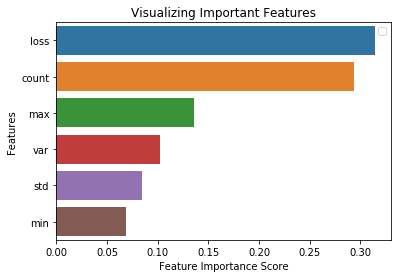

In [31]:
trace_analysis.random_forests_features_selection(X_train, X_test, y_train, y_test, features)

Select relevant features

In [32]:
# separate features from target values
features = stats.drop(columns=['node_id', 'label', 'hop','mean'])
target = stats['label'].values
print('Targets: ' + str(set(target)))

# split dataset into train and test data
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=1)

Targets: {'Normal', 'Black Hole'}


Predicted values

In [33]:
#Create a Gaussian Classifier
rf_clf = RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
rf_clf.fit(X_train,y_train)

y_pred = rf_clf.predict(X_test)


print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

print("\n\n",classification_report(y_test,y_pred))

Accuracy: 0.84


               precision    recall  f1-score   support

  Black Hole       0.95      0.86      0.90        22
      Normal       0.40      0.67      0.50         3

   micro avg       0.84      0.84      0.84        25
   macro avg       0.68      0.77      0.70        25
weighted avg       0.88      0.84      0.86        25



In [55]:
for row in plots:
    label = 'Normal'
    
    # Assign a label
    if row[0].find('gh') >= 0:
        label = 'Gray Hole'
    elif row[0].find('bh') >= 0:
        label = 'Black Hole'
    nodes, packets_node = trace_analysis.process_cooja2_traces(row[0], row[1])

In [54]:
win_packets_node = {}

window_size = 25
node = 'fd00::212:7404:4:404:'

In [94]:
def compute_window_labeled_statistics(nodes, packets_node, label, window_size):
    # Input: a Dataframe nodes = node_id, rank + packets_node = {node_id: node_id, seq, hop, rtt}
    #        and label that indicate the class of the experiment, window_size 
    # Output: compute a dataframe containing node_id, count, mean, var, std, hop, min, max, loss, label for each window
    
    win_stats = None
    for node in packets_node:
        count = packets_node[node]['rtt'].groupby(packets_node[node]['rtt'].index // window_size * window_size).count()
        mean = packets_node[node]['rtt'].groupby(packets_node[node]['rtt'].index // window_size * window_size).mean()
        var = packets_node[node]['rtt'].groupby(packets_node[node]['rtt'].index // window_size * window_size).var()
        std = packets_node[node]['rtt'].groupby(packets_node[node]['rtt'].index // window_size * window_size).std()
        hop = int(nodes[nodes['node_id'] == node]['rank'])
        min_val = packets_node[node]['rtt'].groupby(packets_node[node]['rtt'].index // window_size * window_size).min()
        max_val = packets_node[node]['rtt'].groupby(packets_node[node]['rtt'].index // window_size * window_size).max()
        loss = count.copy().apply(lambda x: 1 - float(x)/window_size)

        
        for index in count.index:
            if win_stats is None:
                win_stats = pd.DataFrame({'node_id': [node],
                                       'count': [count.loc[index]],
                                       'mean': [mean.loc[index]],
                                       'var': [var.loc[index]],
                                       'std': [std.loc[index]],
                                       'hop': [hop],
                                       'min': [min_val.loc[index]],
                                       'max': [max_val.loc[index]],
                                       'loss': [loss.loc[index]],
                                       'label': [label]})
            else:
                win_stats = pd.concat([stats, pd.DataFrame({'node_id': [node],
                                       'count': [count.loc[index]],
                                       'mean': [mean.loc[index]],
                                       'var': [var.loc[index]],
                                       'std': [std.loc[index]],
                                       'hop': [hop],
                                       'min': [min_val.loc[index]],
                                       'max': [max_val.loc[index]],
                                       'loss': [loss.loc[index]],
                                       'label': [label]})])

    return win_stats

In [95]:
trace_statistics.compute_window_labeled_statistics(nodes, packets_node, label, 25)

,node_id,count,mean,var,std,hop,min,max,loss,label
0,fd00::212:7405:5:505:,98,169.887755,4927.317168,70.194851,3,107.0,494.0,0.490,Normal
1,fd00::212:7404:4:404:,87,163.327586,31382.584812,177.151305,2,77.3,1205.0,0.435,Normal
2,fd00::212:7403:3:303:,92,60.042391,5431.264227,73.697111,1,28.3,707.0,0.460,Normal
3,fd00::212:7408:8:808:,90,233.155556,7211.548564,84.920837,4,169.0,929.0,0.450,Normal
4,fd00::212:7402:2:202:,99,145.127273,33352.392004,182.626373,2,69.4,1726.0,0.495,Normal
5,fd00::212:740a:a:a0a:,94,254.223404,30633.917296,175.025476,4,162.0,1584.0,0.470,Normal
6,fd00::212:7409:9:909:,89,224.887640,32428.009959,180.077789,3,125.0,1054.0,0.445,Normal
7,fd00::212:7406:6:606:,99,154.676768,12998.768945,114.012144,2,88.4,871.0,0.495,Normal
8,fd00::212:7407:7:707:,96,173.458333,17333.535088,131.656884,3,109.0,1140.0,0.480,Normal
9,fd00::212:7404:4:404:,88,297.405682,55701.474565,236.011598,2,71.8,1501.0,0.440,Normal
